In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchinfo import summary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from transformers import BertTokenizer, BertModel

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

import os


In [2]:
# Load the CSV file
df = pd.read_csv("data/Fake.csv")

# Get the number of rows in the CSV file
n_rows = len(df)

# Sample 20% of the rows randomly
sample_size = int(n_rows * 0.2)
random_indices = np.random.choice(n_rows, sample_size, replace=False)

# Create a new CSV file with the sampled rows
df_sample = df.iloc[random_indices]
df_sample.to_csv("data/fake_test_20.csv", index=False)

# Save the rest of the rows into a new CSV file
df_rest = df.loc[~df.index.isin(random_indices)]
df_rest.to_csv("data/fake_train_80.csv", index=False)

In [3]:
# Load the CSV file
df = pd.read_csv("data/Real.csv")

# Get the number of rows in the CSV file
n_rows = len(df)

# Sample 20% of the rows randomly
sample_size = int(n_rows * 0.2)
random_indices = np.random.choice(n_rows, sample_size, replace=False)

# Create a new CSV file with the sampled rows
df_sample = df.iloc[random_indices]
df_sample.to_csv("data/real_test_20.csv", index=False)

# Save the rest of the rows into a new CSV file
df_rest = df.loc[~df.index.isin(random_indices)]
df_rest.to_csv("data/real_train_80.csv", index=False)

In [4]:
# Load the data
df_real = pd.read_csv("data/real_train_80.csv") 
df_fake = pd.read_csv("data/fake_train_80.csv")

# Add labels to the datasets
df_fake['isReal'] = 0  # add label
df_real['isReal'] = 1  # add label

# Concatenate real and fake news
df = pd.concat([df_real, df_fake]).reset_index(drop = True)
df.head()

,title,text,subject,date,isReal
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [5]:
# Check if the dataset is class-unbalanced or not
print( df['isReal'].value_counts() )
print()
if 0.9 < (df['isReal'].value_counts()[0] / df['isReal'].value_counts()[1]) < 1.1:
  print('Dataset is class-balanced')
else:
  print('Dataset is class-unbalenced')

isReal
0    18785
1    17134
Name: count, dtype: int64

Dataset is class-balanced


In [6]:
# Combine title and text together
df['combine'] = df['title'] + ' ' + df['text']
# Shuffle the dataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Download stopwords
nltk.download("stopwords")

# Endlish stopwords
stop_words = stopwords.words('english')
stop_words[:10]

# Remove stopwords and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

# Apply the function to the dataframe
df['clean'] = df['combine'].apply(preprocess)

# Join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\frank\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


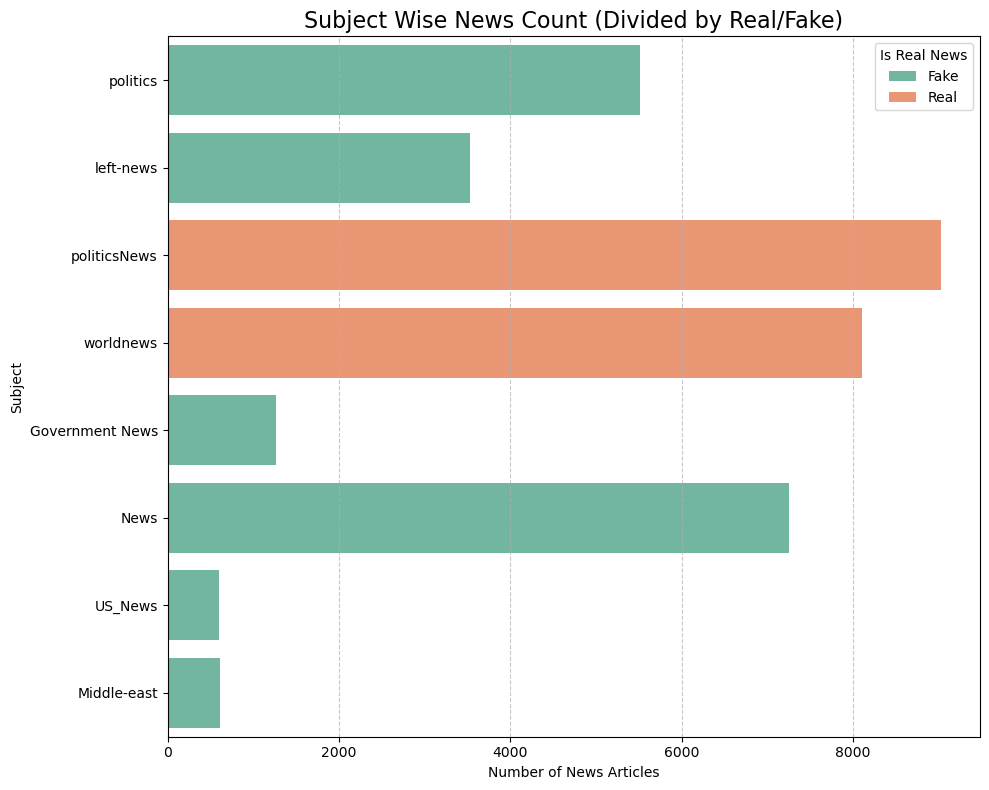

In [7]:
# Plot the number of samples in each subject
plt.figure(figsize=(10, 8))
plt.title("Subject Wise News Count (Divided by Real/Fake)", fontsize=16)

# hue="isReal" splits the bars between real (1) and fake (0)
sns.countplot(y="subject", data=df, hue="isReal", palette="Set2")

plt.xlabel("Number of News Articles")
plt.ylabel("Subject")
plt.legend(title="Is Real News", labels=["Fake", "Real"])
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [8]:
# Drop the 'subject' column as it has a strong correlation with the label
df = df.drop(columns=['subject'])

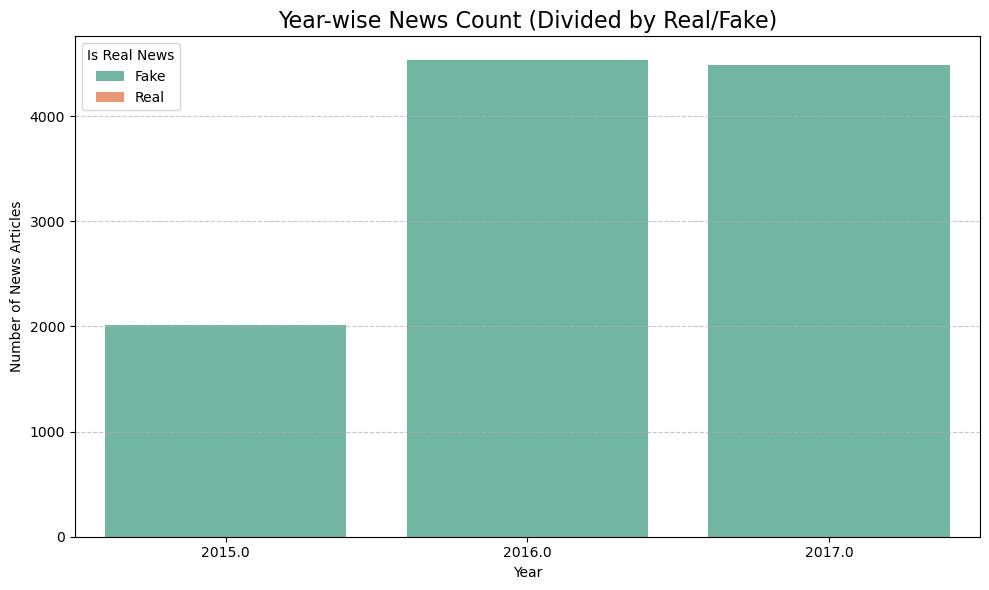

In [9]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extract the year from the date
df['year'] = df['date'].dt.year

plt.figure(figsize=(10, 6))
plt.title("Year-wise News Count (Divided by Real/Fake)", fontsize=16)

# hue="isReal" splits bars into real/fake
sns.countplot(x="year", data=df, hue="isReal", palette="Set2")

plt.xlabel("Year")
plt.ylabel("Number of News Articles")
plt.legend(title="Is Real News", labels=["Fake", "Real"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [10]:
# # Drop the 'date' and 'year'columns as 'year' has a strong correlation with the label
df = df.drop(columns=['date', 'year'])

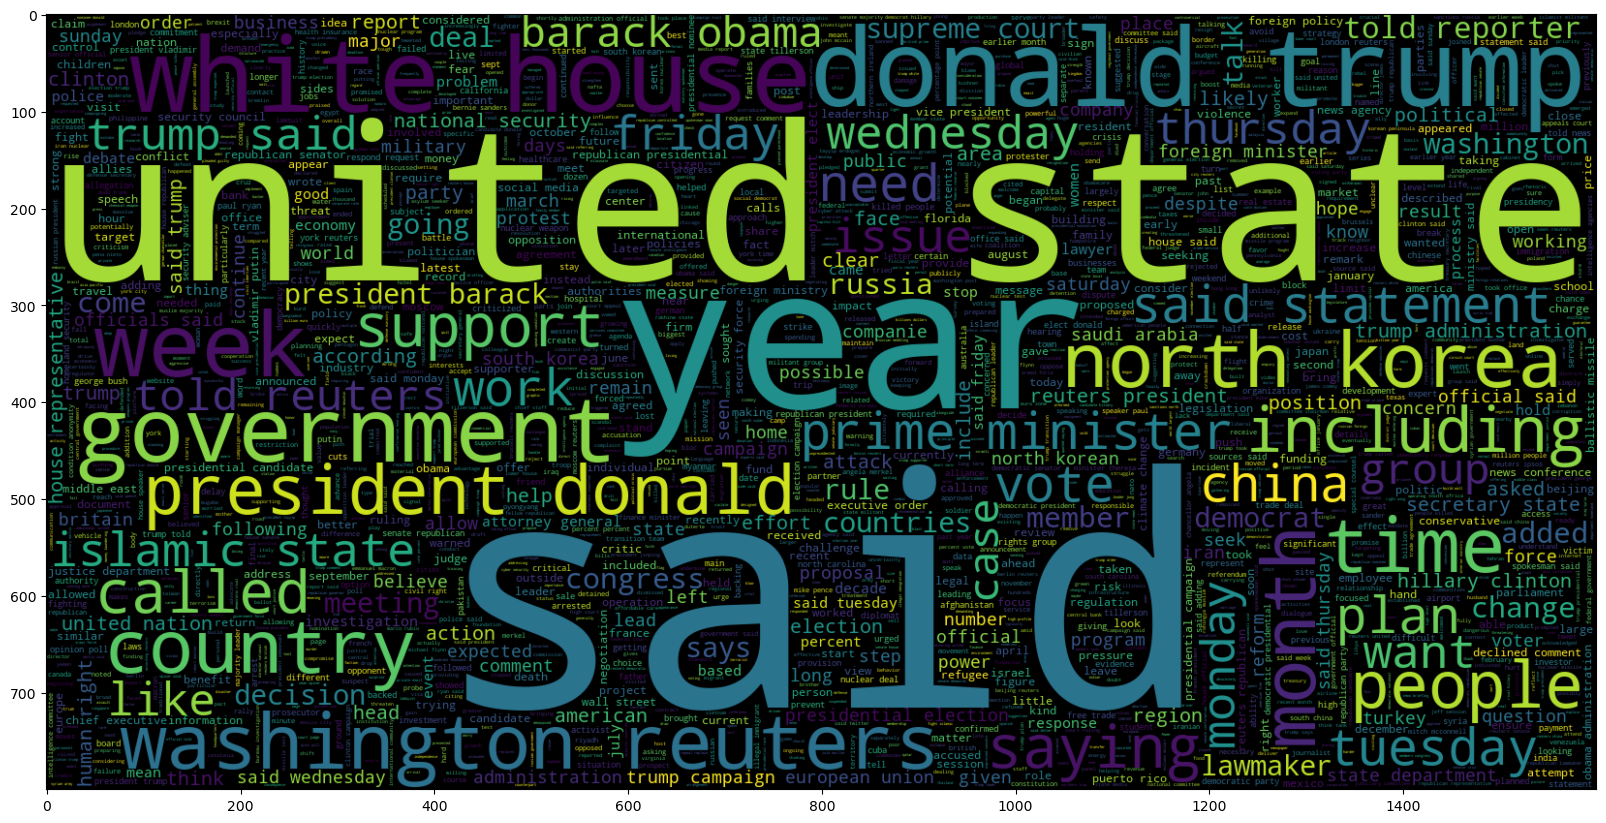

In [11]:
# Plot the word cloud for text that is real
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isReal == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

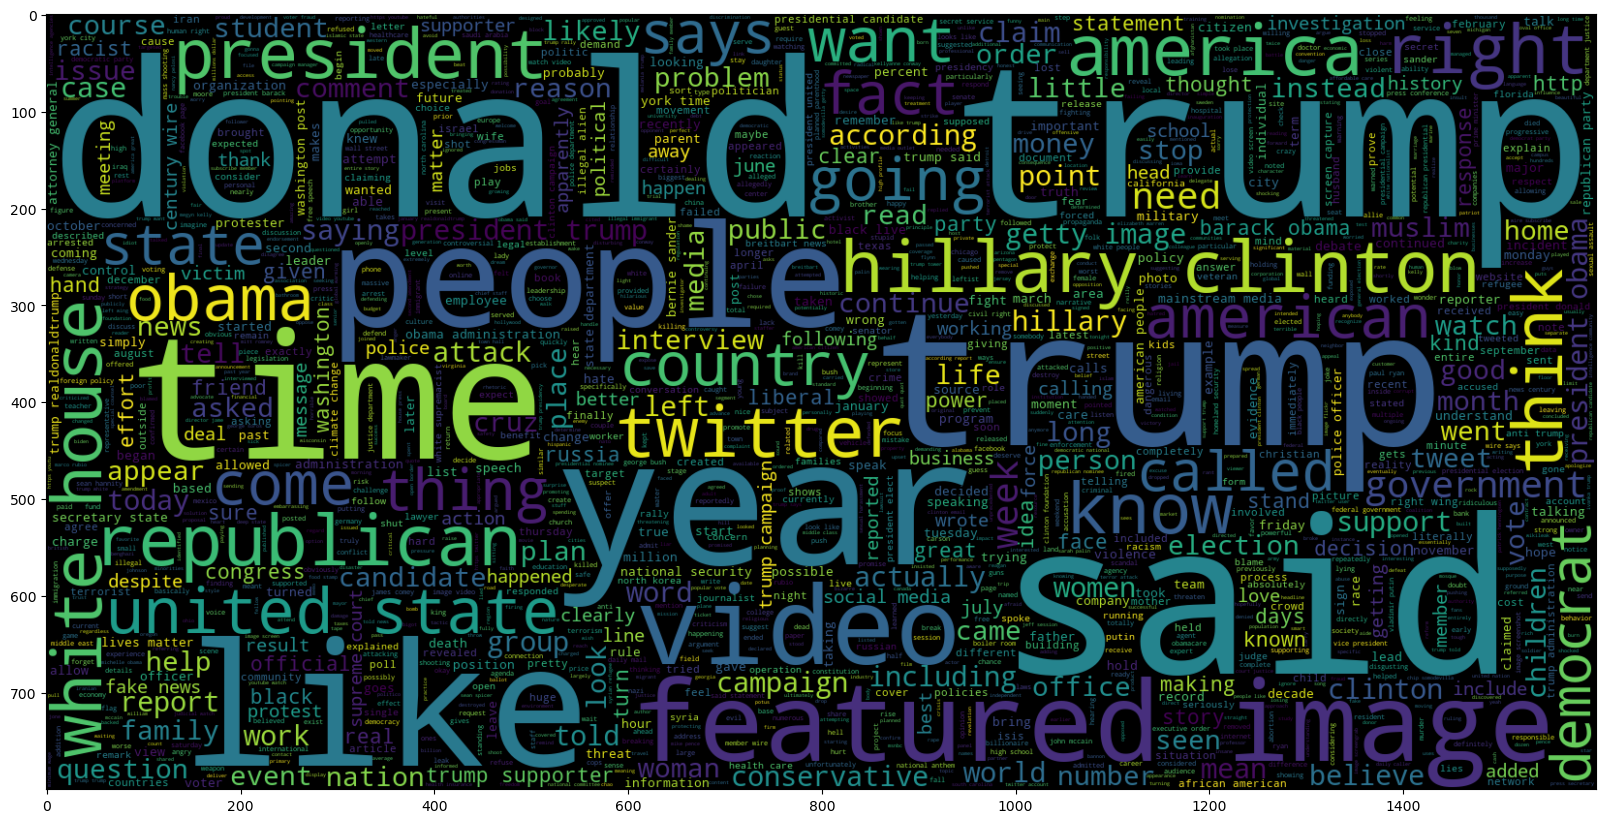

In [12]:
# Plot the word cloud for text that is fake
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isReal == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

In [13]:
nltk.download('punkt')
nltk.download('punkt_tab')
# Determine the maximum number of tokens in any document, required to create word embeddings 
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen < len(tokens)):
        maxlen = len(tokens)
print("The maximum number of tokens in any document is =", maxlen)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\frank\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\frank\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


The maximum number of tokens in any document is = 4405


In [14]:
# Visualize the distribution of number of tokens in a text
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()

In [15]:
# Obtain the total words present in the dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

100162

In [16]:
# Implement BERT classifier in PyTorch with frozen encoder

class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        
        # Load pre-trained BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        
        # Freeze BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False
        
        # Classifier layers
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # shape: (batch_size, seq_length, hidden_size)

        # Global average pooling over the sequence length
        x = last_hidden_state.permute(0, 2, 1)  # (batch_size, hidden_size, seq_length)
        x = self.pool(x).squeeze(-1)             # (batch_size, hidden_size)

        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


In [17]:
# Replace the tokenizer instantiation with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [18]:
# Convert the dataset to features as the input for Bert model
def convert_examples_to_features(texts, tokenizer, max_length=512):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',           
            return_attention_mask=True,
            return_token_type_ids=False,
            truncation=True,
            return_tensors='pt'              # Output as PyTorch tensors directly
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    # Concatenate into big tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

# Apply on the training data
x_train = df['clean_joined']
y_train = torch.tensor(df['isReal'].values)  # Labels as PyTorch tensor

input_ids, attention_mask = convert_examples_to_features(x_train, tokenizer, max_length=512)


In [19]:
# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertClassifier()
model.to(device)  
print(model)

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [20]:
# Create a custom dataset class
class NewsDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }
    
# Create Dataset
train_dataset = NewsDataset(input_ids, attention_mask, y_train)

# Split into train/validation sets 
train_indices, val_indices = train_test_split(
    np.arange(len(train_dataset)),
    test_size=0.2,
    random_state=42,
    shuffle=True
)

train_data = Subset(train_dataset, train_indices)
val_data = Subset(train_dataset, val_indices)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

In [ ]:
# Define optimizer and loss
optimizer = optim.RMSprop(model.parameters(), lr=1e-5)
criterion = nn.BCELoss()  # Binary Cross-Entropy for binary classification

# Training Loop
best_val_loss = float('inf')

for epoch in range(30):  # 30 epochs
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device)  # Important: BCELoss expects float labels

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        outputs = outputs.view(-1)  # Flatten outputs to (batch_size,) for BCELoss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation step
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].float().to(device)

            outputs = model(input_ids, attention_mask)
            outputs = outputs.view(-1)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()

            preds = (outputs > 0.5).float()  # Threshold for binary classification
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct / total

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Acc = {val_accuracy:.4f}")


    # Save best model manually
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "bert_pretrain_classifier.pt")
        print(f"Saved new best model at epoch {epoch+1}!")

Epoch 1: Train Loss = 0.2245, Val Loss = 0.2187, Val Acc = 0.9108
Saved new best model at epoch 1!
Epoch 2: Train Loss = 0.2188, Val Loss = 0.2209, Val Acc = 0.9085
Epoch 3: Train Loss = 0.2166, Val Loss = 0.2081, Val Acc = 0.9163
Saved new best model at epoch 3!
Epoch 4: Train Loss = 0.2115, Val Loss = 0.1987, Val Acc = 0.9220
Saved new best model at epoch 4!
Epoch 5: Train Loss = 0.2074, Val Loss = 0.1977, Val Acc = 0.9234
Saved new best model at epoch 5!
Epoch 6: Train Loss = 0.2043, Val Loss = 0.1981, Val Acc = 0.9229
Epoch 7: Train Loss = 0.2030, Val Loss = 0.1988, Val Acc = 0.9205
Epoch 8: Train Loss = 0.2018, Val Loss = 0.1888, Val Acc = 0.9273
Saved new best model at epoch 8!
Epoch 9: Train Loss = 0.1979, Val Loss = 0.1892, Val Acc = 0.9275
Epoch 10: Train Loss = 0.1972, Val Loss = 0.1858, Val Acc = 0.9286
Saved new best model at epoch 10!
